In [1]:
import json
import csv

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
path = "/home/tim62119/Documents/Repos/arise-prototype/data/"
order_file = "Arbeitsgänge Fastec 2024_01-06.xlsx"
setup_file = "Rüstzeitauswertung_formatiert.xlsx"

df_orders = pd.read_excel(path+order_file)
df_setup = pd.read_excel(path+setup_file)

In [3]:
# merging information about production runs and setup time
df_setup = df_setup[["Auftrag", "geplante Rüstzeit", "Rüstzeit"]]
df = pd.merge(df_orders, df_setup, left_on="Fertigungsauftrag", right_on="Auftrag")

print(f"Before merge: {df_orders.shape}, after merge: {df.shape}")
df.head()

Before merge: (6067, 27), after merge: (6040, 30)


,Arbeitsgang,Fertigungsauftrag,Artikel,Artikelbezeichnung,Artikelbeschreibung,Fertigungsversion,Fertigungsversionsbezeichnung,Arbeitsplan,Arbeitsplanbezeichnung,Frühester Start,...,Ausschuss-Menge,Mengeneinheit,Ist-Start,Ist-Ende,Geplanter Start,Geplantes Ende,Rüstgruppe,Auftrag,geplante Rüstzeit,Rüstzeit
0,1,151642.1,41730,BC 2.30 FSC-Mix 70%,BC 2.30 FSC-Mix 70%,NaN,NaN,NaN,NaN,2023-12-19 06:00:00,...,NaN,Stk,2024-01-02 08:32:33.573,2024-01-02 09:40:44.630,NaN,NaN,NaN,151642.1,0 days 00:20:00,0 days 00:00:44
1,1,151389.1,16122,B 1.03 FSC Mix 70%,B 1.03 FSC Mix 70%,NaN,NaN,NaN,NaN,2024-01-08 06:00:00,...,NaN,Stk,2024-01-02 08:42:03.450,2024-01-02 09:38:33.450,NaN,NaN,NaN,151389.1,0 days 00:50:00,0 days 00:00:53
2,1,151874.1,29929,B 1.03 FSC Mix 70%,B 1.03 FSC Mix 70%,NaN,NaN,NaN,NaN,2024-01-04 12:57:00,...,NaN,Stk,2024-01-02 08:51:04.730,2024-01-02 08:51:28.470,NaN,NaN,NaN,151874.1,0 days 00:00:24,0 days 00:00:24
3,1,151791.1,41763,EB 2.31 FSC Mix 70%,EB 2.31 FSC Mix 70%,NaN,NaN,NaN,NaN,2024-01-03 07:17:00,...,NaN,Stk,2024-01-02 08:51:33.827,2024-01-02 09:30:28.800,NaN,NaN,NaN,151791.1,0 days 00:14:00,0 days 00:10:46
4,1,151591.1,41721,BC 2.50,BC 2.50,NaN,NaN,NaN,NaN,2024-01-03 08:04:00,...,NaN,Stk,2024-01-02 08:52:49.460,2024-01-02 09:26:44.220,NaN,NaN,NaN,151591.1,0 days 00:33:55,0 days 00:12:51


In [4]:
# check if Aufträge were mapped correctly
print((df["Auftrag"] == df["Fertigungsauftrag"]).all())

True


Adding features

In [5]:
# add actual length of each production run
df["Ist-Dauer"] = df["Ist-Ende"] - df["Ist-Start"]

# add end month of each production run as string
month_map = {
    1: 'Januar',
    2: 'Februar',
    3: 'März',
    4: 'April',
    5: 'Mai',
    6: 'Juni',
    7: 'Juli',
    8: 'August',
    9: 'September',
    10: 'Oktober',
    11: 'November',
    12: 'Dezember'
}
df["ende_monat"] = df["Ist-Ende"].dt.month.map(month_map)  # get the month as the German name
df['ende_monat'] = pd.Categorical(df['ende_monat'], categories=month_map.values())  # turn into categorical

# add column with information about material
df["material"] = df["Artikelbezeichnung"].str.split(' ', n=1).str[0]

# add information about Abweichung from Soll vs Ist Rüstzeit
# SOLL - IST => positive values when enough time was planned, negative otherwise
df["rüstzeit_abweichung"] = df["geplante Rüstzeit"] - df["Rüstzeit"]

# add information about time buffer between latest and actual end date
df["time_buffer"] = df["Spätestes Ende"] - df["Ist-Ende"]

# impute empty cells with 0 for Ausschuss Menge
df['Ausschuss-Menge'] = df['Ausschuss-Menge'].fillna(0.0)

In [5]:
n_unique_articles = df["Artikel"].nunique()
n_rows = df.shape[0]
print(f"There are {n_rows} production logs from {n_unique_articles} unique articles.")

There are 6040 production logs from 4022 unique articles.


How many products were produced multiple times in the current timeframe?

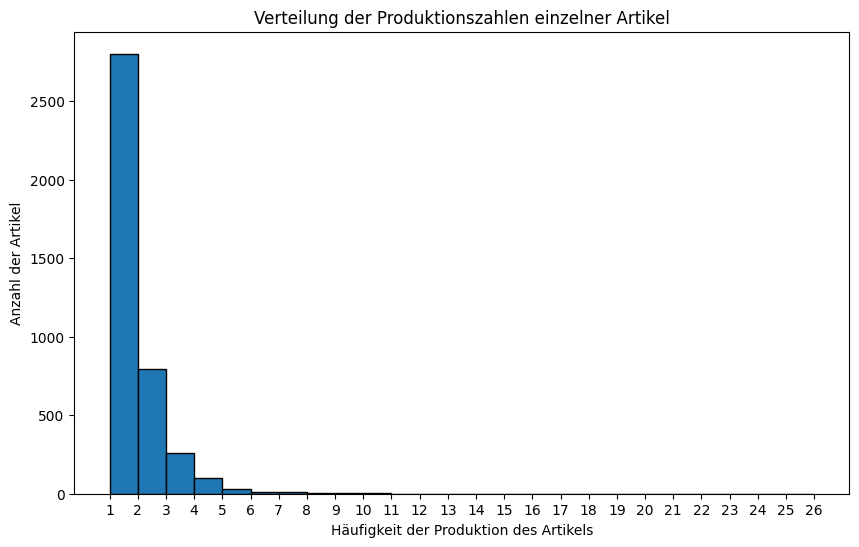

In [10]:
article_counts = df['Artikel'].value_counts()

plt.figure(figsize=(10, 6))
plt.hist(article_counts, bins=range(1, article_counts.max() + 1), edgecolor='black')
plt.title('Verteilung der Produktionszahlen einzelner Artikel')
plt.xlabel('Häufigkeit der Produktion des Artikels')
plt.ylabel('Anzahl der Artikel')
plt.xticks(range(1, article_counts.max() + 1))

plt.show()

When where these products produced?

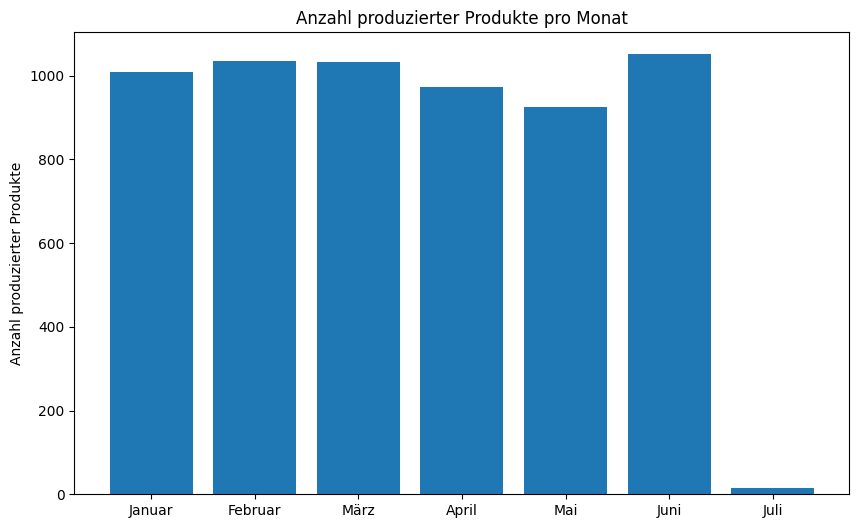

In [70]:
group_names = df['ende_monat'].unique()
# production counts of each month (which is present in the dataset) in order
prod_counts = df["ende_monat"].value_counts().sort_index().iloc[:group_names.shape[0]]

plt.figure(figsize=(10, 6))
plt.bar(list(range(prod_counts.shape[0])), prod_counts.values)
plt.title('Anzahl produzierter Produkte pro Monat')
plt.xticks(list(range(prod_counts.shape[0])), group_names)
plt.ylabel('Anzahl produzierter Produkte')

plt.show()

Produzierte Aufträge pro Material

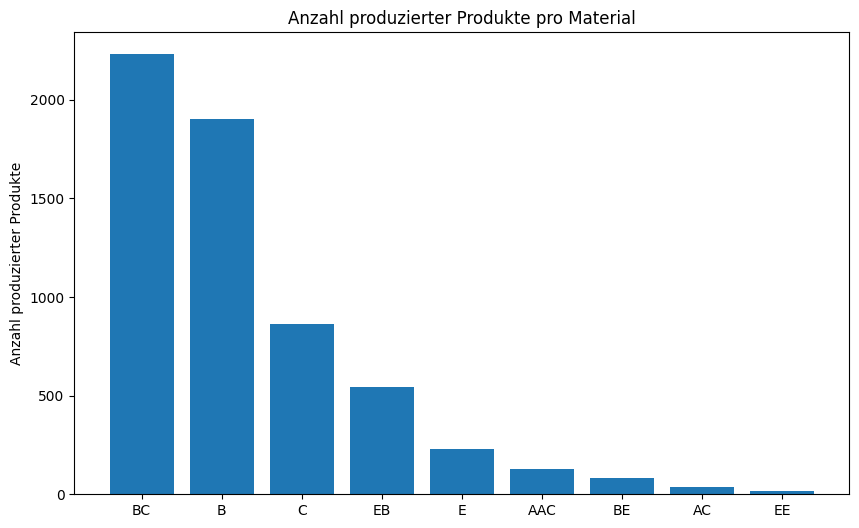

In [19]:
prod_counts = df["material"].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(list(range(prod_counts.shape[0])), prod_counts.values)
plt.title('Anzahl produzierter Produkte pro Material')
plt.xticks(list(range(prod_counts.shape[0])), prod_counts.index)
plt.ylabel('Anzahl produzierter Produkte')

plt.show()

Produzierte Aufträge pro Arbeitsplatz

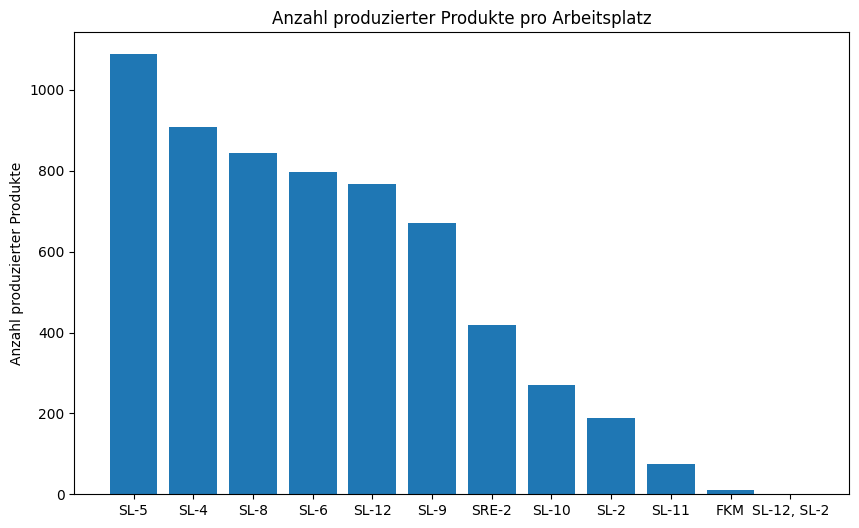

In [22]:
prod_counts = df["Arbeitsplätze (möglich)"].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(list(range(prod_counts.shape[0])), prod_counts.values)
plt.title('Anzahl produzierter Produkte pro Arbeitsplatz')
plt.xticks(list(range(prod_counts.shape[0])), prod_counts.index)
plt.ylabel('Anzahl produzierter Produkte')

plt.show()

Remove "FKM" and "SL-12, SL-2" because of too little samples

In [12]:
n_before = df.shape[0]
df = df[~df['Arbeitsplätze (möglich)'].isin(["FKM", "SL-12, SL-2"])]
n_after = df.shape[0]
print(f"{n_before-n_after} rows removed.")

11 rows removed.


# Rüstzeiten

Is there a general over- or underestimation of Rüstzeiten?

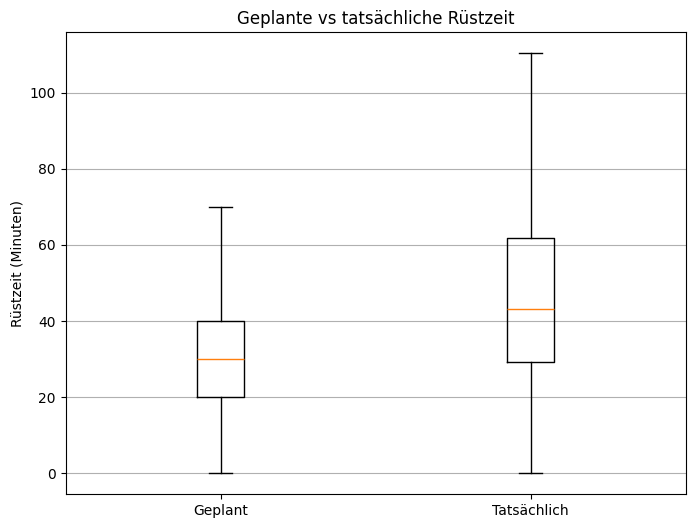

In [97]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['geplante Rüstzeit'].dt.total_seconds() / 60, positions=[0], showfliers=False)
plt.boxplot(df['Rüstzeit'].dt.total_seconds() / 60, positions=[1], showfliers=False)

plt.title('Geplante vs tatsächliche Rüstzeit')
plt.ylabel('Rüstzeit (Minuten)')
plt.xticks([0, 1], ["Geplant", "Tatsächlich"])  # To label the x-axis with the column name
plt.grid(axis='y')

plt.show()

Deviation from Soll- vs Ist-Rüstzeit

Durchschnittliche Abweichung pro Fertigungsauftrag: 16.67 Minuten
Bei 1000 Aufträgen pro Monat sind das 35 Arbeitstage pro Monat


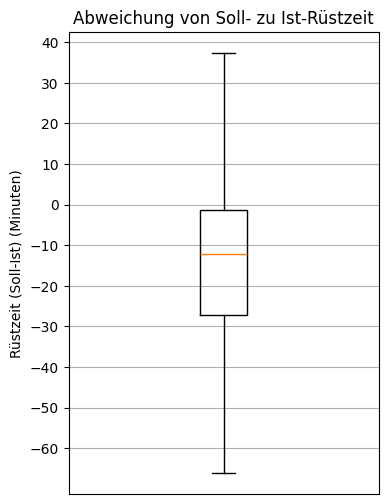

In [106]:
mean_deviation = df["rüstzeit_abweichung"].mean().total_seconds()/60
print(f"Durchschnittliche Abweichung pro Fertigungsauftrag: {round(abs(mean_deviation), 2)} Minuten")

plt.figure(figsize=(4, 6))
plt.boxplot(df['rüstzeit_abweichung'].dt.total_seconds() / 60, showfliers=False)

plt.title('Abweichung von Soll- zu Ist-Rüstzeit')
plt.ylabel('Rüstzeit (Soll-Ist) (Minuten)')
plt.xticks([], [])  # To label the x-axis with the column name
plt.yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40])
plt.grid(axis='y')

plt.show()

Rüstzeit pro Material

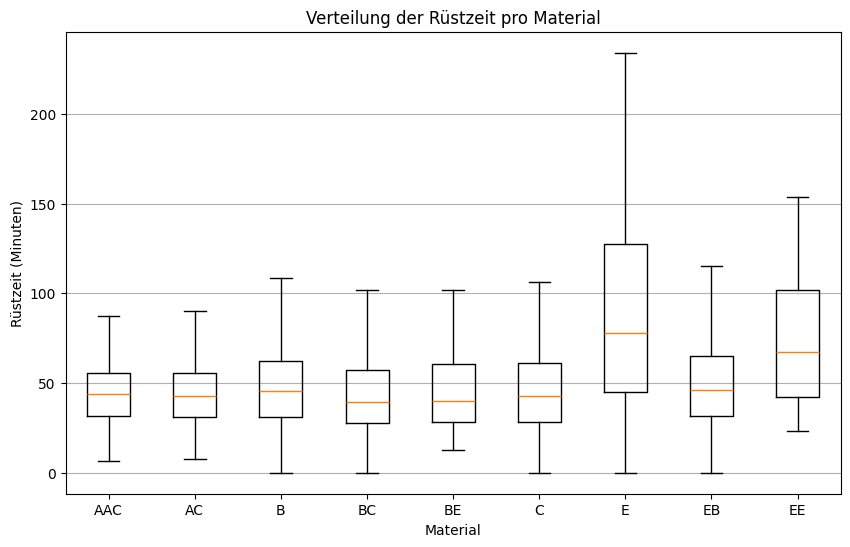

In [23]:
grouped_data = [(group['Rüstzeit'].dt.total_seconds() / 60, name) for name, group in df.groupby('material')]
grouped_values = [x[0] for x in grouped_data]
group_names = [x[1] for x in grouped_data]

plt.figure(figsize=(10, 6))
plt.boxplot(grouped_values, tick_labels=group_names, showfliers=False)
plt.title('Verteilung der Rüstzeit pro Material')
plt.ylabel('Rüstzeit (Minuten)')
plt.xlabel('Material')
plt.grid(axis='y', which='major')

plt.show()

Rüstzeitabweichung pro Material

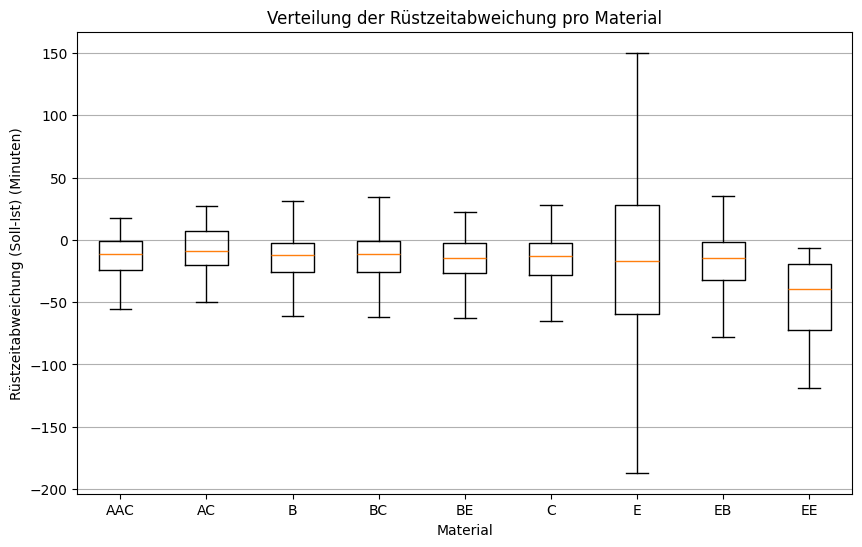

In [24]:
grouped_data = [(group['rüstzeit_abweichung'].dt.total_seconds() / 60, name) for name, group in df.groupby('material')]
grouped_values = [x[0] for x in grouped_data]
group_names = [x[1] for x in grouped_data]

plt.figure(figsize=(10, 6))
plt.boxplot(grouped_values, tick_labels=group_names, showfliers=False)
plt.title('Verteilung der Rüstzeitabweichung pro Material')
plt.ylabel('Rüstzeitabweichung (Soll-Ist) (Minuten)')
plt.xlabel('Material')
plt.grid(axis='y', which='major')

plt.show()

Rüstzeit pro Arbeitsplatz

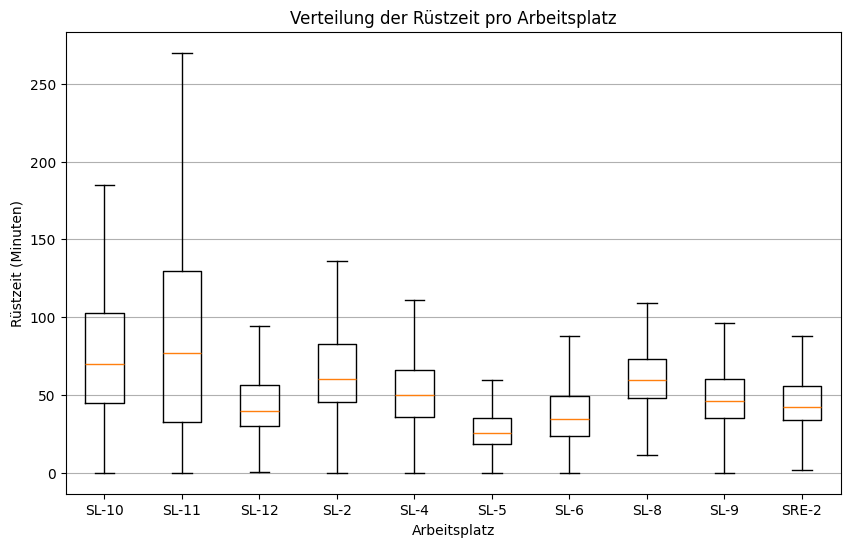

In [30]:
grouped_data = [(group['Rüstzeit'].dt.total_seconds() / 60, name) for name, group in df.groupby('Arbeitsplätze (möglich)')]
grouped_values = [x[0] for x in grouped_data]
group_names = [x[1] for x in grouped_data]

plt.figure(figsize=(10, 6))
plt.boxplot(grouped_values, tick_labels=group_names, showfliers=False)
plt.title('Verteilung der Rüstzeit pro Arbeitsplatz')
plt.ylabel('Rüstzeit (Minuten)')
plt.xlabel('Arbeitsplatz')
plt.grid(axis='y', which='major')

plt.show()

Rüstzeitabweichung pro Arbeitsplatz

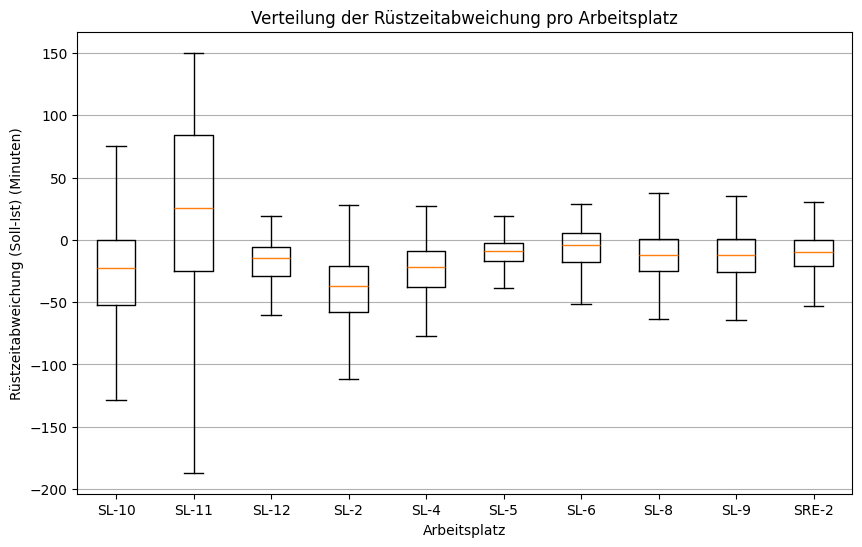

In [31]:
grouped_data = [(group['rüstzeit_abweichung'].dt.total_seconds() / 60, name) for name, group in df.groupby('Arbeitsplätze (möglich)')]
grouped_values = [x[0] for x in grouped_data]
group_names = [x[1] for x in grouped_data]

plt.figure(figsize=(10, 6))
plt.boxplot(grouped_values, tick_labels=group_names, showfliers=False)
plt.title('Verteilung der Rüstzeitabweichung pro Arbeitsplatz')
plt.ylabel('Rüstzeitabweichung (Soll-Ist) (Minuten)')
plt.xlabel('Arbeitsplatz')
plt.grid(axis='y', which='major')

plt.show()

Co-occurence von Material und Arbeitsplätzen

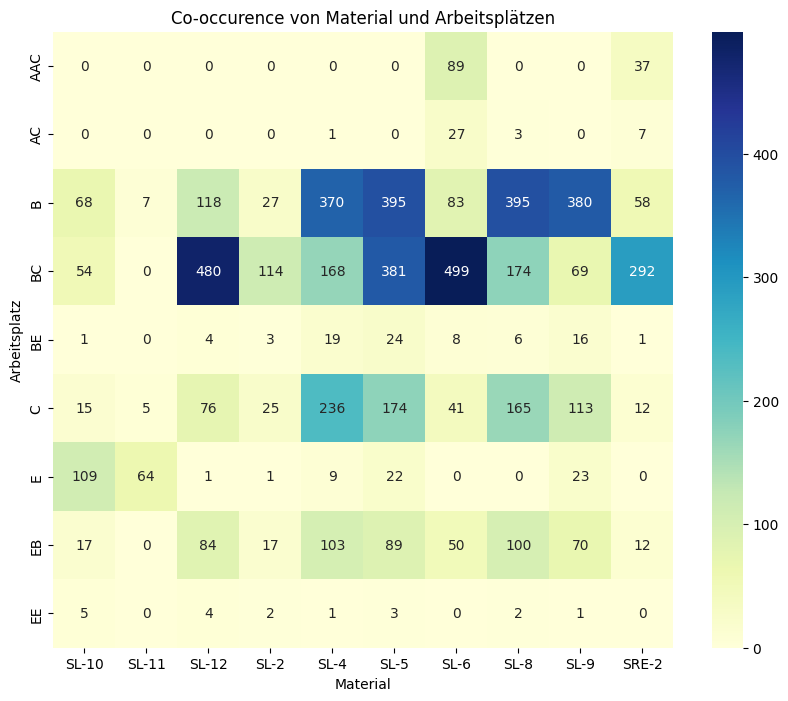

In [25]:
heatmap_data = pd.crosstab(df['material'], df['Arbeitsplätze (möglich)'])

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')

plt.title('Co-occurence von Material und Arbeitsplätzen')
plt.xlabel('Material')
plt.ylabel('Arbeitsplatz')
plt.show()

Rüstzeit von Material zu Material

In [26]:
# for each machine -> sort by end_timestamp -> iterate over and Rüstzeit in dictionary with last and current

In [27]:
df['Rüstzeit'].dt.total_seconds()/60

0        0.733333
1        0.883333
2        0.400000
3       10.766667
4       12.850000
          ...    
6035    33.083333
6036     0.316667
6037    33.483333
6038     0.100000
6039    35.666667
Name: Rüstzeit, Length: 6029, dtype: float64

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['material', 'previous_material', 'ist_start_hour', 'Arbeitsplätze (möglich)']], df['Rüstzeit'].dt.total_seconds()/60, test_size=.2)

# Produktionszeiten

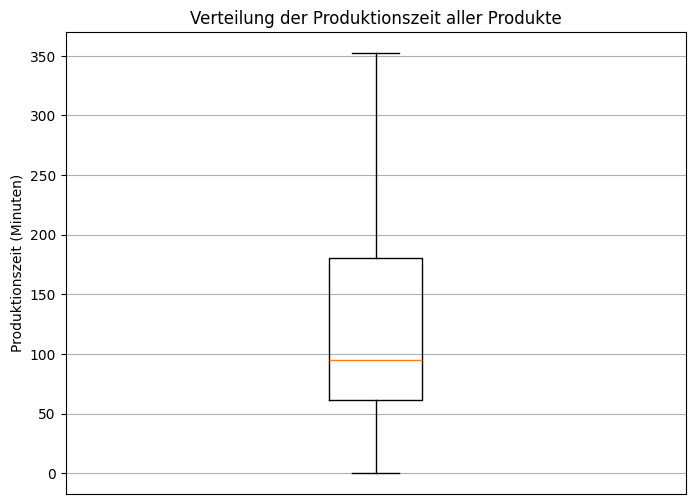

In [6]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['Ist-Dauer'].dt.total_seconds() / 60, showfliers=False)

plt.title('Verteilung der Produktionszeit aller Produkte')
plt.ylabel('Produktionszeit (Minuten)')
plt.xticks([], [])  # To label the x-axis with the column name
plt.grid(axis='y')

plt.show()

In [12]:
total = df.shape[0]
not_in_time = df[df["time_buffer"].dt.total_seconds() < 0].shape[0]
print(f"total: {total}")
print(f"not in time: {not_in_time}")

total: 6040
not in time: 2744


Termintreue: 54.6% der Aufträge wurden vor dem spätesten Ende fertiggestellt.


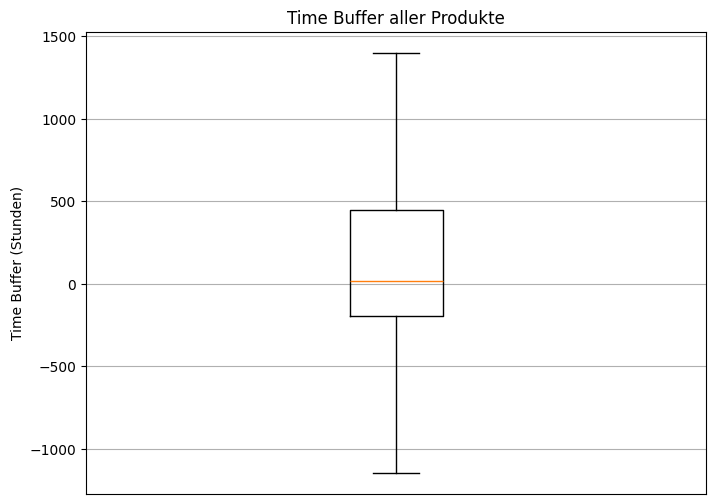

In [7]:
total = df.shape[0]
in_time = df[df["time_buffer"].dt.total_seconds() >= 0].shape[0]
print(f"Termintreue: {round(in_time/total*100, 1)}% der Aufträge wurden vor dem spätesten Ende fertiggestellt.")

plt.figure(figsize=(8, 6))
plt.boxplot(df['time_buffer'].dt.total_seconds() / 360, showfliers=False)

plt.title('Time Buffer aller Produkte')
plt.ylabel('Time Buffer (Stunden)')
plt.xticks([], [])  # To label the x-axis with the column name
plt.grid(axis='y')

plt.show()

### Time Buffer pro Material

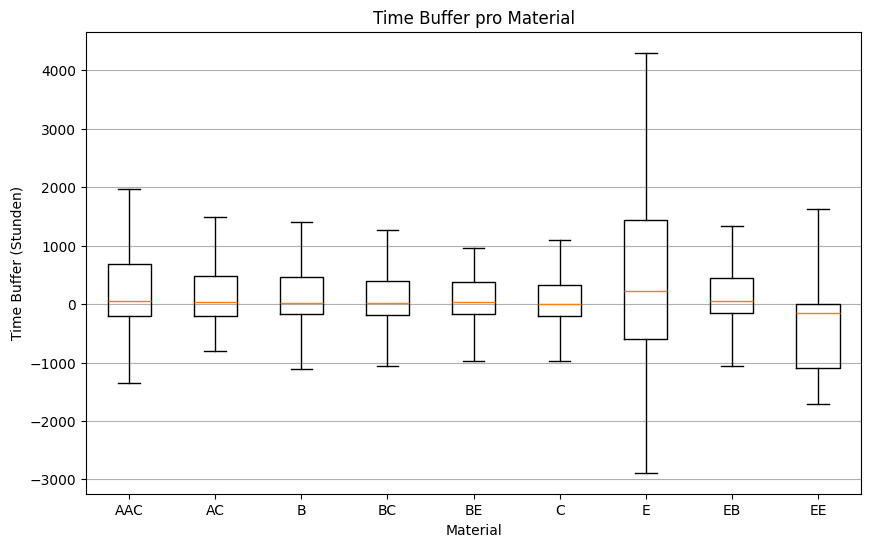

In [39]:
grouped_data = [(group['time_buffer'].dt.total_seconds() / 360, name) for name, group in df.groupby('material')]
grouped_values = [x[0] for x in grouped_data]
group_names = [x[1] for x in grouped_data]

plt.figure(figsize=(10, 6))
plt.boxplot(grouped_values, tick_labels=group_names, showfliers=False)
plt.title('Time Buffer pro Material')
plt.ylabel('Time Buffer (Stunden)')
plt.xlabel('Material')
plt.grid(axis='y')

plt.show()

### Produktionszeit pro Material

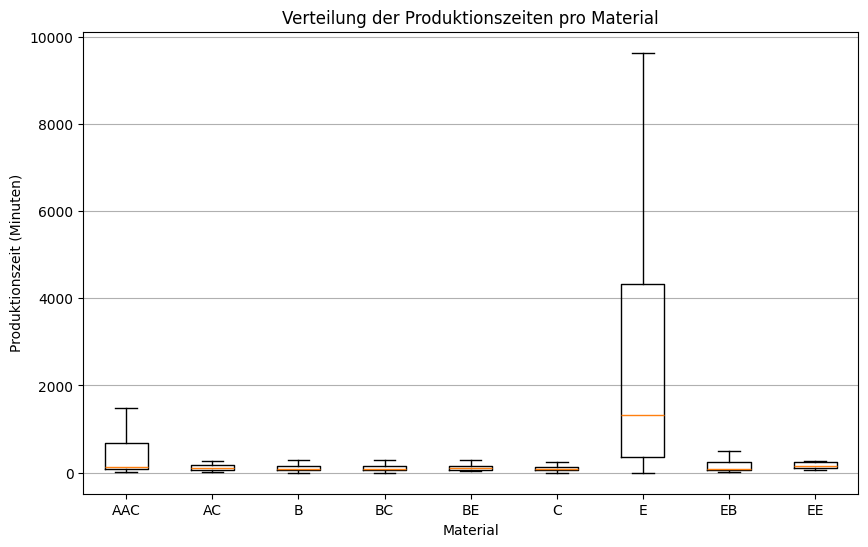

In [9]:
grouped_data = [(group['Ist-Dauer'].dt.total_seconds() / 60, name) for name, group in df.groupby('material')]
grouped_values = [x[0] for x in grouped_data]
group_names = [x[1] for x in grouped_data]

plt.figure(figsize=(10, 6))
plt.boxplot(grouped_values, tick_labels=group_names, showfliers=False)
plt.title('Verteilung der Produktionszeiten pro Material')
plt.ylabel('Produktionszeit (Minuten)')
plt.xlabel('Material')
plt.grid(axis='y')

plt.show()

Ohne E

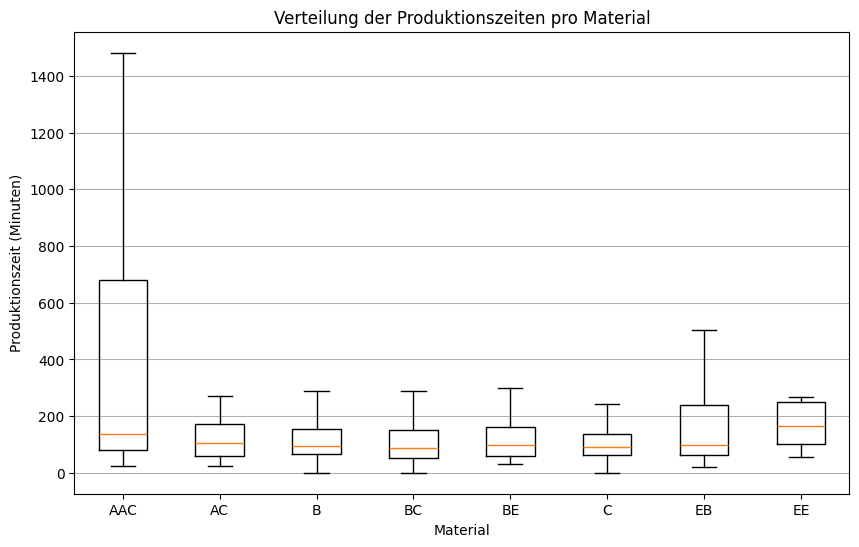

In [10]:
grouped_data = [(group['Ist-Dauer'].dt.total_seconds() / 60, name) for name, group in df.groupby('material')]
grouped_values = [x[0] for x in grouped_data if not x[1]=='E']
group_names = [x[1] for x in grouped_data if not x[1]=='E']

plt.figure(figsize=(10, 6))
plt.boxplot(grouped_values, tick_labels=group_names, showfliers=False)
plt.title('Verteilung der Produktionszeiten pro Material')
plt.ylabel('Produktionszeit (Minuten)')
plt.xlabel('Material')
plt.grid(axis='y')

plt.show()

# Produzierte Mengen

Ausschuss pro Material

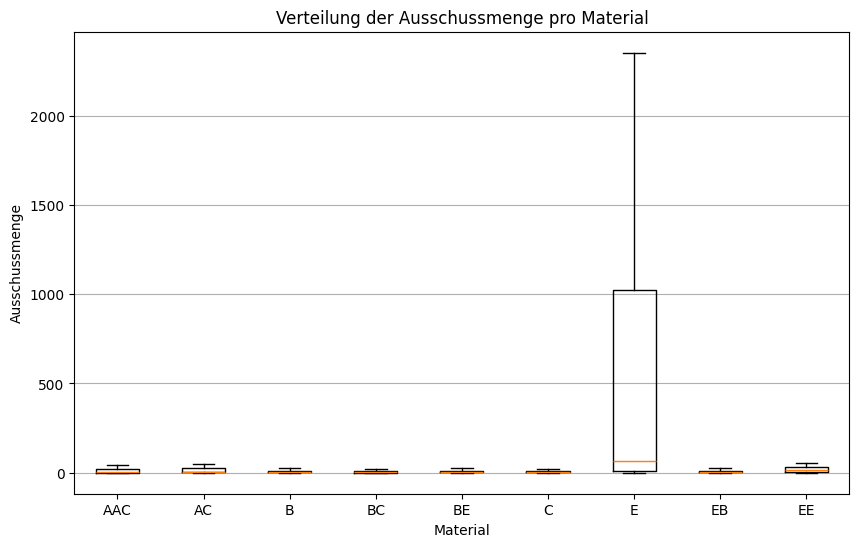

In [17]:
grouped_data = [(group['Ausschuss-Menge'], name) for name, group in df.groupby('material')]
group_values = [x[0] for x in grouped_data]
group_names = [x[1] for x in grouped_data]

plt.figure(figsize=(10, 6))
plt.boxplot(group_values, tick_labels=group_names, showfliers=False)
plt.title('Verteilung der Ausschussmenge pro Material')
plt.ylabel('Ausschussmenge')
plt.xlabel('Material')
plt.grid(axis='y', which='major')

plt.show()

Ohne E

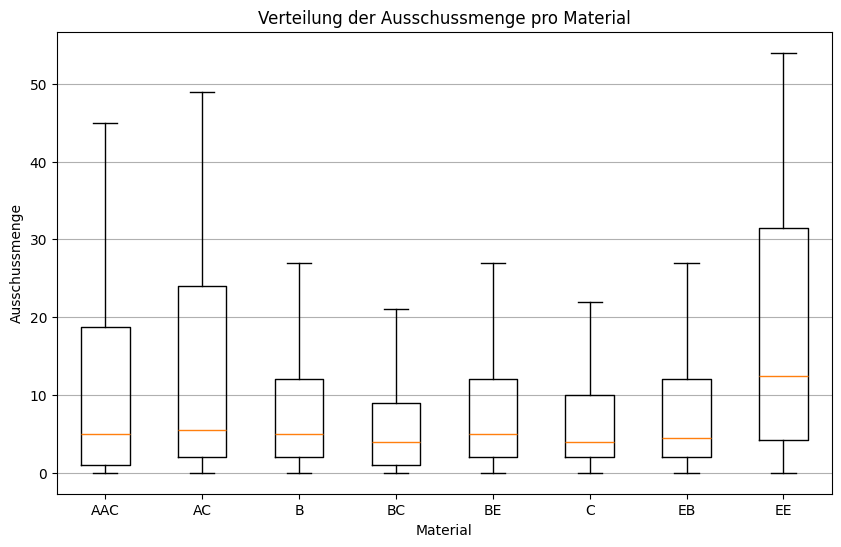

In [18]:
grouped_data = [(group['Ausschuss-Menge'], name) for name, group in df.groupby('material')]
group_values = [x[0] for x in grouped_data if not x[1]=='E']
group_names = [x[1] for x in grouped_data if not x[1]=='E']

plt.figure(figsize=(10, 6))
plt.boxplot(group_values, tick_labels=group_names, showfliers=False)
plt.title('Verteilung der Ausschussmenge pro Material')
plt.ylabel('Ausschussmenge')
plt.xlabel('Material')
plt.grid(axis='y', which='major')

plt.show()

Ausschuss pro Maschine

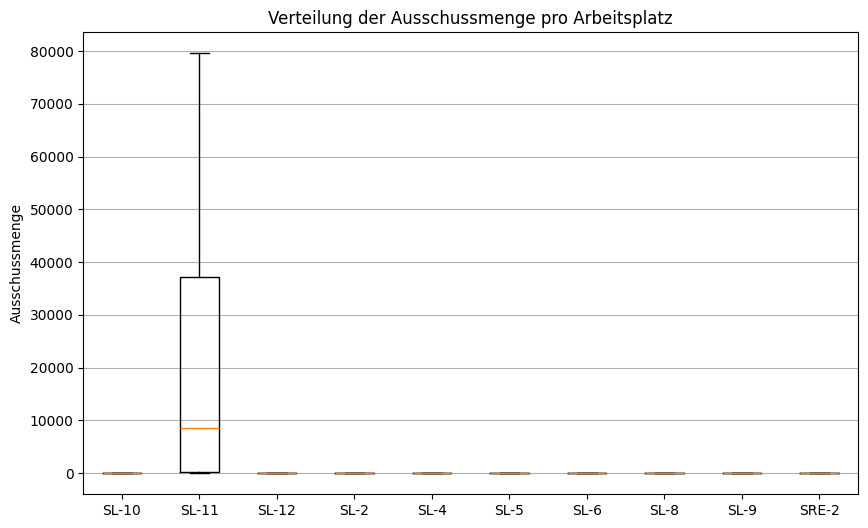

In [16]:
grouped_data = [(group['Ausschuss-Menge'], name) for name, group in df.groupby('Arbeitsplätze (möglich)')]
group_values = [x[0] for x in grouped_data]
group_names = [x[1] for x in grouped_data]

plt.figure(figsize=(10, 6))
plt.boxplot(group_values, tick_labels=group_names, showfliers=False)
plt.title('Verteilung der Ausschussmenge pro Arbeitsplatz')
plt.ylabel('Ausschussmenge')
plt.grid(axis='y', which='major')

plt.show()

Ohne SL-11

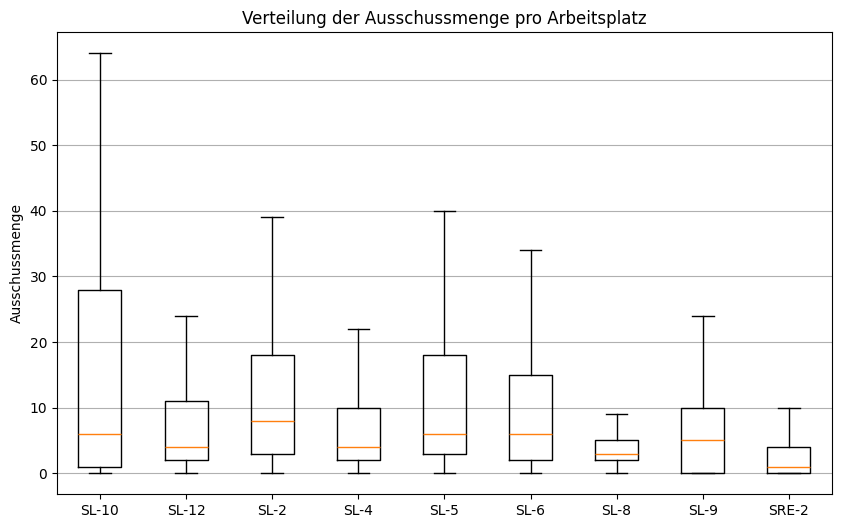

In [15]:
grouped_data = [(group['Ausschuss-Menge'], name) for name, group in df.groupby('Arbeitsplätze (möglich)')]
group_values = [x[0] for x in grouped_data if not x[1]=='SL-11']
group_names = [x[1] for x in grouped_data if not x[1]=='SL-11']

plt.figure(figsize=(10, 6))
plt.boxplot(group_values, tick_labels=group_names, showfliers=False)
plt.title('Verteilung der Ausschussmenge pro Arbeitsplatz')
plt.ylabel('Ausschussmenge')
plt.grid(axis='y', which='major')

plt.show()